In [18]:
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam, SGD

# import from models.IMDBSimpleNN import IMDBSimpleNN
from IMDBSimpleNN import IMDBSimpleNN

In [2]:
class ReviewDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [3]:
df = pd.read_csv('../datasets/IMDB.csv')

In [4]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(df['review']).toarray()
y = (df['sentiment'] == 'positive').astype(float) 

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_dataset = ReviewDataset(X_train, y_train)
test_dataset = ReviewDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [5]:
class SentimentClassifier(nn.Module):
    def __init__(self, input_dim):
        # we need 0.5 dropout to avoid overfitting
        super(SentimentClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.5)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return self.sigmoid(x)

In [7]:

from torch import optim
# from SignSGD import SignSGD

def train_with_optimizer(model, optimizer_type, train_loader, num_epochs=10):
    model = SentimentClassifier(input_dim=1000)
    print(optimizer_type)
    
    if optimizer_type == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    elif optimizer_type == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=0.001)
    elif optimizer_type == 'adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=0.001)
    # elif optimizer_type == 'signsgd':
    #     optimizer = SignSGD(model.parameters(), lr=0.001)
    else:
        raise ValueError("Optimizer type not supported.")
    
    criterion = nn.CrossEntropyLoss()
    
    model.train()
    print(f"Training with {optimizer_type}")
    
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    
    losses = []
    num_epochs = 10
    # loss per epoch
    start_time = time.time()

    epoch_times = []
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}")
        start_time_epoch = time.time()
        
        epoch_losses = []
        for i, (reviews, labels) in enumerate(train_loader):
            # Forward pass
            outputs = model(reviews)
            loss = criterion(outputs.squeeze(), labels)
            epoch_losses += [loss.item()]
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()
            
        losses.append(sum(epoch_losses) / len(epoch_losses))
        
        scheduler.step()
        
        end_time_epoch = time.time()
        
        epoch_times.append(end_time_epoch - start_time_epoch)

    end_time = time.time()
    duration = end_time - start_time
    avg_epoch_time = sum(epoch_times) / len(epoch_times)
    
    return model, losses, avg_epoch_time

In [19]:
optimizers = ["adam", "sgd", "adagrad"]

losses_per_optimizer = {}
execution_times_per_optimizer = {}
accuracies_per_optimizer = {}

model = IMDBSimpleNN(input_dim=1000)

for optimizer in optimizers:
    model, losses, avg_epoch_time = train_with_optimizer(model, optimizer, train_loader)
    
    losses_per_optimizer[optimizer] = losses
    execution_times_per_optimizer[optimizer] = avg_epoch_time
    
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for reviews, labels in test_loader:
            outputs = model(reviews)
            predicted = (outputs.squeeze() > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f'Accuracy of the network on the {total} test reviews: {100 * correct / total} %')
    
    accuracies_per_optimizer[optimizer] = 100 * correct / total

/Users/teframartin/EPFL_Cours/MA4/OptiMlForever/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Training with adam
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Accuracy of the network on the 10000 test reviews: 85.93 %
Training with sgd
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Accuracy of the network on the 10000 test reviews: 85.58 %
Training with adagrad
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Accuracy of the network on the 10000 test reviews: 85.92 %


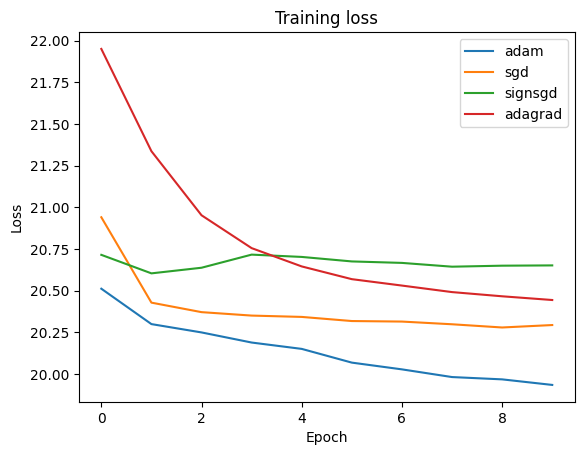

In [ ]:
import matplotlib.pyplot as plt

# plot for each optimizer
for optimizer_name, losses in losses_per_optimizer.items():
    plt.plot(losses, label=optimizer_name)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training loss')
    plt.legend()

In [ ]:
accuracies_per_optimizer, execution_times_per_optimizer

({'adam': 86.03, 'sgd': 84.85, 'signsgd': 84.54, 'adagrad': 85.92},
 {'adam': 3.047320818901062,
  'sgd': 1.8578943967819215,
  'signsgd': 1.7995237350463866,
  'adagrad': 2.2107659339904786})